# User Behavior Analysis for the “Unused Things” App

###  Project Overview and Goals

### **Research Goal:**  

Managing **user engagement** (**adapting the app for core and adjacent audiences**) is only relevant when based on **actual behavioral data**.  

● **Goal** — to generate hypotheses from user behavior that could help improve the app’s user experience.  

---

### **Hypotheses:**  

● Users who perform both `tip_click` and `tip_show` have a higher conversion rate** than those who only perform `tip_show`.  

● Users whose session source is `yandex` have a higher conversion rate** than users coming from `google`.  

---

### **Tasks:**  

● Analyze the relationship** between the target event (viewing seller contacts) and other user actions.  

● Evaluate which actions are more common among users who view contacts.  

---

### **Data Description:**  

● **Columns in `/datasets/mobile_sources.csv`:**  
- userId — user identifier  
- source — the channel where the user installed the app  

● **Columns in `/datasets/mobile_dataset.csv`:**  
- event.time — timestamp of the action  
- user.id — user identifier  
- event.name — type of user action  

● **Types of actions:**  
- advert_open — opened an ad card  
- photos_show — viewed photos in the ad  
- tips_show — saw recommended ads  
- tips_click — clicked a recommended ad  
- contacts_show / show_contacts — viewed phone number  
- contacts_call — called the number from an ad  
- map — opened the ads map**  
- search_1 — search_7 — different search actions on the site  
- favorites_add — added an ad to favorites  

### Data Loading

In [66]:
# importing libraries
from scipy import stats as st
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import seaborn as sns
import plotly.express as px
from datetime import datetime as dt
from datetime import timedelta
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import requests
from tqdm import tqdm
from datetime import datetime, timedelta
import math as mth
import plotly.io as pio
pio.renderers.default = 'notebook'

In [67]:
# loading dataset
try:
    df = pd.read_csv('/datasets/mobile_dataset.csv')
except:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/mobile_dataset.csv')

In [68]:
# loading dataset
try:
    df_sources = pd.read_csv('/datasets/mobile_sources.csv')
except:
    df_sources = pd.read_csv('https://code.s3.yandex.net/datasets/mobile_sources.csv')

In [69]:
# checking basic info
print(df.info())
df_sources.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74197 entries, 0 to 74196
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   event.time  74197 non-null  object
 1   event.name  74197 non-null  object
 2   user.id     74197 non-null  object
dtypes: object(3)
memory usage: 1.7+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4293 entries, 0 to 4292
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   userId  4293 non-null   object
 1   source  4293 non-null   object
dtypes: object(2)
memory usage: 67.2+ KB


In [70]:
#pd.set_option('display.max_columns', None)
df.head()

event.time   event.name  \
0  2019-10-07 00:00:00.431357  advert_open   
1  2019-10-07 00:00:01.236320    tips_show   
2  2019-10-07 00:00:02.245341    tips_show   
3  2019-10-07 00:00:07.039334    tips_show   
4  2019-10-07 00:00:56.319813  advert_open   

                                user.id  
0  020292ab-89bc-4156-9acf-68bc2783f894  
1  020292ab-89bc-4156-9acf-68bc2783f894  
2  cf7eda61-9349-469f-ac27-e5b6f5ec475c  
3  020292ab-89bc-4156-9acf-68bc2783f894  
4  cf7eda61-9349-469f-ac27-e5b6f5ec475c

In [71]:
#pd.set_option('display.max_columns', None)
df_sources.head()

userId  source
0  020292ab-89bc-4156-9acf-68bc2783f894   other
1  cf7eda61-9349-469f-ac27-e5b6f5ec475c  yandex
2  8c356c42-3ba9-4cb6-80b8-3f868d0192c3  yandex
3  d9b06b47-0f36-419b-bbb0-3533e582a6cb   other
4  f32e1e2a-3027-4693-b793-b7b3ff274439  google

#### Сonclusion for this section:

1. Column names in the sessions dataset are not in snake_case, and the session time dtype is not converted to datetime  
2. The sessions dataset has 74,197 records, the sources dataset has 4,293 records  
3. Both datasets share a common field — user_id

### Data preprocessing

#### Missing values check

In [72]:
# checking for missing values
df.isna().sum().sort_values(ascending=False)

event.time    0
event.name    0
user.id       0
dtype: int64

In [73]:
# checking missing values
df_sources.isna().sum().sort_values(ascending=False)

userId    0
source    0
dtype: int64

#### Column names and data types

In [74]:
# renaming columns in both dataframes
df.columns = ['event_time','event_name','user_id']

In [75]:
# renaming columns in both datasets
df_sources.columns = ['user_id','source']

In [76]:
# checking unique event values
df['event_name'].unique()

array(['advert_open', 'tips_show', 'map', 'contacts_show', 'search_4',
       'search_5', 'tips_click', 'photos_show', 'search_1', 'search_2',
       'search_3', 'favorites_add', 'contacts_call', 'search_6',
       'search_7', 'show_contacts'], dtype=object)

In [77]:
# replacing event names of the target metric with a unified one
df['event_name'] = df['event_name'].replace("contacts_show", "show_contacts")

In [78]:
# function to group website search event names
def web_search(row):
    try:
        if 'search_' in row:
            return 'search'
        else:
            return row
    except:
        pass

In [79]:
# replacing website search action names with a unified one for easier grouping
df['event_name'] = df['event_name'].apply(web_search)

In [80]:
df['event_name'].unique()

array(['advert_open', 'tips_show', 'map', 'show_contacts', 'search',
       'tips_click', 'photos_show', 'favorites_add', 'contacts_call'],
      dtype=object)

In [81]:
# converting session time to datetime format without milliseconds
df['event_time'] = pd.to_datetime(df['event_time']).dt.floor('S')

In [82]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74197 entries, 0 to 74196
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   event_time  74197 non-null  datetime64[ns]
 1   event_name  74197 non-null  object        
 2   user_id     74197 non-null  object        
dtypes: datetime64[ns](1), object(2)
memory usage: 1.7+ MB


In [83]:
df.head(2)

event_time   event_name                               user_id
0 2019-10-07 00:00:00  advert_open  020292ab-89bc-4156-9acf-68bc2783f894
1 2019-10-07 00:00:01    tips_show  020292ab-89bc-4156-9acf-68bc2783f894

#### Handling duplicates

In [84]:
# checking explicit duplicates
df.duplicated().sum()

1224

In [85]:
df = df.drop_duplicates()

In [86]:
# checking implicit duplicates
df[['event_time','user_id','event_name']].duplicated().sum()

0

In [87]:
# checking obvious duplicates
df_sources.duplicated().sum()

0

In [88]:
## checking unique source names
df_sources['source'].unique()

array(['other', 'yandex', 'google'], dtype=object)

#### Conclusion for this section:

1. No missing values found  
2. The value **"contact_show"** was replaced with **"show_contacts"**  
3. Actions related to site search **search1...searchN** were replaced with **"website_search"**  
4. Explicit duplicates removed — **2% of the data**  
5. Columns in both datasets converted to **snake_case**  
6. Session time column converted to **datetime**, truncated to seconds  
7. Two new columns added

### Session definition

#### Determining the number of unique users

In [89]:
len(df['user_id'].unique())

4293

#### Timeout definition

In [90]:
# sorting the dataframe by user and event time
# grouping events by user
# calculating the time delta between consecutive events within each user; the first event has 0
# in minutes
df['time_diff'] = (df
                    .sort_values(['user_id', 'event_time']) 
                    .groupby('user_id')['event_time']
                    .diff()
                    .dt.total_seconds().fillna(0) / 60.0
                  )

In [91]:
df.head()

event_time   event_name                               user_id  \
0 2019-10-07 00:00:00  advert_open  020292ab-89bc-4156-9acf-68bc2783f894   
1 2019-10-07 00:00:01    tips_show  020292ab-89bc-4156-9acf-68bc2783f894   
2 2019-10-07 00:00:02    tips_show  cf7eda61-9349-469f-ac27-e5b6f5ec475c   
3 2019-10-07 00:00:07    tips_show  020292ab-89bc-4156-9acf-68bc2783f894   
4 2019-10-07 00:00:56  advert_open  cf7eda61-9349-469f-ac27-e5b6f5ec475c   

   time_diff  
0   0.000000  
1   0.016667  
2   0.000000  
3   0.100000  
4   0.900000

In [92]:
df['time_diff'].describe()

count    72973.000000
mean       223.219484
std       1501.100963
min          0.000000
25%          0.300000
50%          1.100000
75%          2.850000
max      38269.900000
Name: time_diff, dtype: float64

In [93]:
# calculating percentiles
np.percentile(
    (df.groupby(['user_id','event_time'])['time_diff'].mean()),
    [80,85,87,90,92,95]
            )

array([  3.81666667,   5.81666667,   7.58333333,  14.68166667,
        36.6       , 471.26      ])

#### Session definition

In [94]:
# defining sessions with a 10-minute timeout
g = (
    df.sort_values(['user_id', 'event_time'])
    .groupby('user_id')['event_time'].diff() > pd.Timedelta(15, 'minutes')
    ).cumsum()

#### Adding columns

In [95]:
# creating session_id column
df['session_id'] = (df
                    .sort_values(['user_id', 'event_time'])
                    .groupby(['user_id', g], sort=False)
                    .ngroup() + 1
                   )
df.head()

event_time   event_name                               user_id  \
0 2019-10-07 00:00:00  advert_open  020292ab-89bc-4156-9acf-68bc2783f894   
1 2019-10-07 00:00:01    tips_show  020292ab-89bc-4156-9acf-68bc2783f894   
2 2019-10-07 00:00:02    tips_show  cf7eda61-9349-469f-ac27-e5b6f5ec475c   
3 2019-10-07 00:00:07    tips_show  020292ab-89bc-4156-9acf-68bc2783f894   
4 2019-10-07 00:00:56  advert_open  cf7eda61-9349-469f-ac27-e5b6f5ec475c   

   time_diff  session_id  
0   0.000000          82  
1   0.016667          82  
2   0.000000        9326  
3   0.100000          82  
4   0.900000        9326

In [96]:
# determining the number of sessions
print('Number of Unique Sessions:', max(df['session_id']))

Number of Unique Sessions: 11537


In [97]:
# extracting the start and end time for each session_id
start_time = df.groupby('session_id').agg({'event_time' : [np.min]}).reset_index()
start_time.columns = ['session_id','session_start']
end_time = df.groupby('session_id').agg({'event_time' : [np.max]}).reset_index()
end_time.columns = ['session_id','session_end']

In [98]:
# adding columns to the main dataframe
df = df.merge(start_time, on='session_id')
df = df.merge(end_time, on='session_id')

In [99]:
# adding session year, month, and duration columns
df['session_dur'] = (df['session_end'] - df['session_start']).dt.total_seconds() / 60.0
df['session_year'] = df['session_start'].dt.year
df['session_month'] = df['session_start'].dt.month
df['session_week'] = df['session_start'].dt.isocalendar().week
df['session_date'] = df['session_start'].dt.date
df.head(2)

event_time   event_name                               user_id  \
0 2019-10-07 00:00:00  advert_open  020292ab-89bc-4156-9acf-68bc2783f894   
1 2019-10-07 00:00:01    tips_show  020292ab-89bc-4156-9acf-68bc2783f894   

   time_diff  session_id session_start         session_end  session_dur  \
0   0.000000          82    2019-10-07 2019-10-07 00:18:42         18.7   
1   0.016667          82    2019-10-07 2019-10-07 00:18:42         18.7   

   session_year  session_month  session_week session_date  
0          2019             10            41   2019-10-07  
1          2019             10            41   2019-10-07

#### Conclusion for this section:

1. **15 minutes** — chosen as the session timeout (inactivity interval after which a session is considered finished), based on the 90th percentile  
2. Added columns: **session_id, session_year, session_month, session_start, session_end, session_dur**  
3. Number of unique users — **4,293**  
4. Number of sessions — **11,537**

### Exploratory data analysis

#### General metrics analysis

Define the existing events and their distribution by count.  
The **tips_show** action does not depend on the user, so it will be excluded from some calculations.

In [100]:
events = df[df['event_name'] != "tips_show"]['event_name'].value_counts().reset_index()
events.head()

index  event_name
0    photos_show        9352
1         search        6684
2    advert_open        6146
3  show_contacts        4376
4            map        3749

In [101]:
# calculating the percentage of action categories
events['total'] = events['event_name'].sum()

events['group_percent'] = round(events['event_name']/events['total'],2)
                                    
#events.head(2)

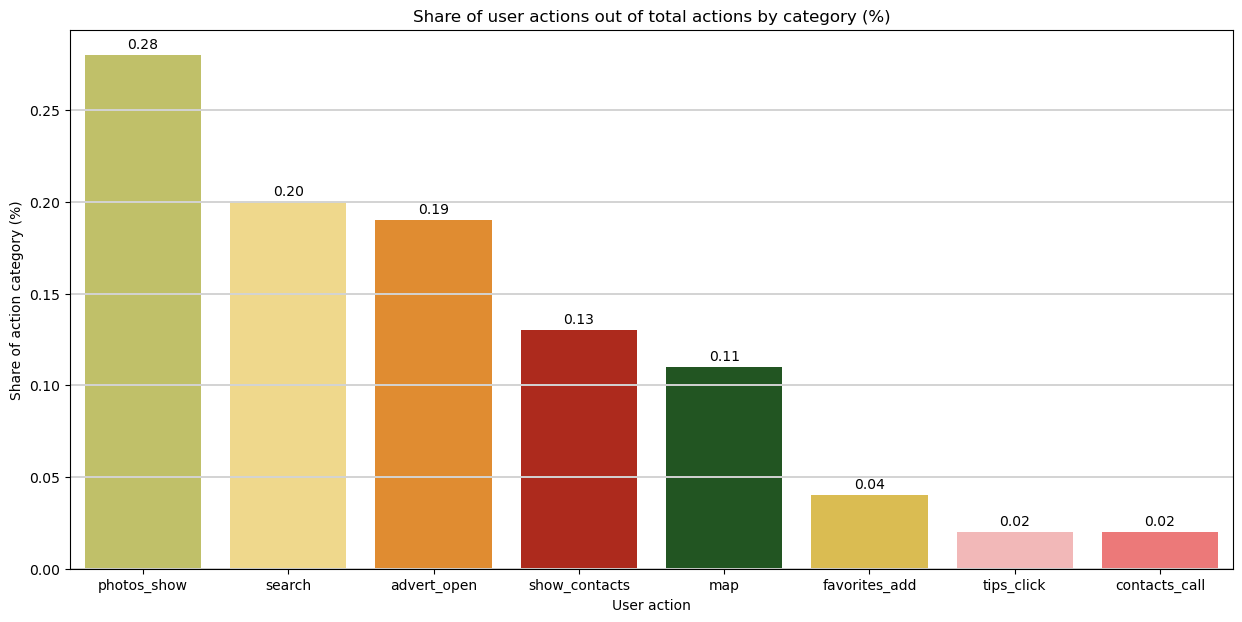

In [102]:
colors = (['#CECE5A', '#FFE17B','#FD8D14','#C51605','#1A5D1A','#F1C93B','#FCAEAE',
           '#FF6666','#DF826C','#F4F27E','#994D1C','#C683D7','#F05941','#FF6C22','#FECDA6']
         )

# number of events by categories
fig, ax = plt.subplots(figsize=(15, 7))
fig.patch.set_facecolor('xkcd:white') # This changes the grey to white
ax.set_facecolor("white")
plt.grid(True, color = "lightgrey", linewidth = "1.4", linestyle = "-")
        
plots = sns.barplot(data = events, x = 'index', y = 'group_percent', palette=colors, ax=ax)

for bar in plots.patches:
   
  # Using Matplotlib's annotate function and
  # passing the coordinates where the annotation shall be done
  # x-coordinate: bar.get_x() + bar.get_width() / 2
  # y-coordinate: bar.get_height()
  # free space to be left to make graph pleasing: (0, 8)
  # ha and va stand for the horizontal and vertical alignment
    plots.annotate(format(bar.get_height(), '.2f'), 
                   (bar.get_x() + bar.get_width() / 2, 
                    bar.get_height()), ha='center', va='center',
                   size=10, xytext=(0, 8),
                   textcoords='offset points')

ax.set(xlabel='User action', ylabel='Share of action category (%)')
plt.title('Share of user actions out of total actions by category (%)')
plt.show()

**Conclusion:**  

1. Most frequently, users perform **photos_show** — 28% of all actions  
2. Users rarely click on recommendations — only **2%** of actions  
3. Other shares: **search — 20%**, **advert_open — 19%**, **show_contacts — 13%**

#### User behavior scenarios analysis

It is necessary to **identify** user scenarios and key patterns leading to the **target event**, excluding duplicate events within the same session.  

First, determine the share of repeated events across sessions:

In [103]:
print(
    'Average number of repeated events:',
    round(df.duplicated(subset=['session_id','event_name']).mean(), 2)
)

Average number of repeated events: 0.74


Such events will have to be excluded from the analysis (**72% of events**), as they are not significant for identifying user scenarios.

**Create a table with scenario data:**

In [104]:
# creating a table with sessions and events, sorted by time within each session
scenario = (
            df
            .drop_duplicates(subset=['session_id','event_name'])
            .sort_values(by=['session_id','event_time'])[['session_id','event_name']]
#            .set_index('session_id')
            )
scenario.head(2)

session_id event_name
799            1  tips_show
6490           2        map

In [105]:
# creating a column that concatenates all events within each session
scenario['scenario_list'] = scenario.groupby(['session_id'])['event_name'].transform(','.join)

In [106]:
# adding the number of events per session
scenario['events_in_session'] = scenario.groupby('session_id')['session_id'].transform(lambda x: x.count())

In [107]:
# creating a column with the order of each event in the session
scenario['step'] = scenario.groupby('session_id').cumcount() + 1

In [108]:
# creating a function that flags whether the target action was performed in the session
def show_contact_flg(row):
    try:
        if 'show_contact' in row:
            return True
        else:
            return False
    except:
        pass

In [109]:
# adding a column with a flag for performing the target action
scenario['show_contact_flg'] = scenario['scenario_list'].apply(show_contact_flg)

In [110]:
scenario.head(5)

session_id event_name  scenario_list  events_in_session  step  \
799             1  tips_show      tips_show                  1     1   
6490            2        map  map,tips_show                  2     1   
6492            2  tips_show  map,tips_show                  2     2   
35907           3  tips_show  tips_show,map                  2     1   
35909           3        map  tips_show,map                  2     2   

       show_contact_flg  
799               False  
6490              False  
6492              False  
35907             False  
35909             False

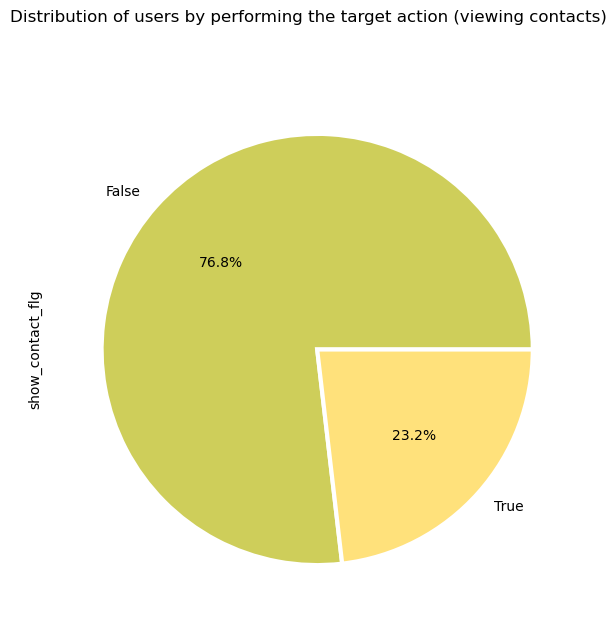

In [111]:
# venue categories
colors = ['#CECE5A', '#FFE17B']

# creating a pivot table by categories and plotting a chart
scenario['show_contact_flg'].value_counts().sort_values(ascending=False).plot(
    kind='pie',
    figsize=(7, 7),
    legend=False,
    title='Distribution of users by performing the target action (viewing contacts)',
    subplots=True,
    autopct='%1.1f%%',
    wedgeprops={'linewidth': 3, 'edgecolor': 'white'},
    colors=colors
)
plt.show()

**Conclusion:**  
1. Users perform the contact view action in **22%** of cases.

Let's look at the number of repeating scenarios:

In [112]:
#pd.set_option('display.max_rows', 20)
#pd.set_option('display.max_columns', 10)
scenario['scenario_list'].value_counts().sort_values(ascending=False).reset_index().head(10)

index  scenario_list
0                  tips_show           3191
1                photos_show           1505
2              map,tips_show           1138
3         search,photos_show           1048
4                     search            867
5           search,tips_show            832
6    tips_show,show_contacts            774
7  map,advert_open,tips_show            537
8              tips_show,map            432
9      advert_open,tips_show            336

**It is clear that the top-3 scenarios consist of one or two actions.**  

Let's see what share of scenarios they represent:  

<em>(calculations are based on sessions, not on the scenario column, since we need to find the number of sessions that repeat the same scenario or a scenario with identical selection criteria)</em>

In [113]:
print('share of sessions with one action:',
    round((len(scenario.query('events_in_session == 1')['session_id'].unique()) /
    len(scenario)), 2)
)

print('share of sessions with two actions:',
    round((len(scenario.query('events_in_session == 2')['session_id'].unique()) /
    len(scenario)), 2)
)

share of sessions with one action: 0.33
share of sessions with two actions: 0.18


In total, such sessions make up **50%**.  

Let's check the share of these sessions in **Group A** (target action performed) and **Group B** (target action not performed).

In [114]:
print('number of sessions in group A:',
    len(scenario.query('show_contact_flg == True')['session_id'].unique())
)

number of sessions in group A: 1858


In [115]:
print('share of sessions with 1 action in group A:',
    round(
        len(scenario.query('events_in_session == 1 and show_contact_flg == True')['session_id'].unique())
        / len(scenario.query('show_contact_flg == True')['session_id'].unique()),
    2)
)

print('share of sessions with 2 actions in group A:',
    round(
        len(scenario.query('events_in_session == 2 and show_contact_flg == True')['session_id'].unique())
        / len(scenario.query('show_contact_flg == True')['session_id'].unique()),
    2)
)

print('share of sessions with 3 actions in group A:',
    round(
        len(scenario.query('events_in_session == 3 and show_contact_flg == True')['session_id'].unique())
        / len(scenario.query('show_contact_flg == True')['session_id'].unique()),
    2)
)

print('share of sessions with 4 actions in group A:',
    round(
        len(scenario.query('events_in_session == 4 and show_contact_flg == True')['session_id'].unique())
        / len(scenario.query('show_contact_flg == True')['session_id'].unique()),
    3)
)

share of sessions with 1 action in group A: 0.14
share of sessions with 2 actions in group A: 0.46
share of sessions with 3 actions in group A: 0.29
share of sessions with 4 actions in group A: 0.079


In [116]:
print('number of sessions in group B:',
    len(scenario.query('show_contact_flg == False')['session_id'].unique())
)

number of sessions in group B: 9679


In [117]:
print('share of sessions with 1 action in group B:',
    round(
        len(scenario.query('events_in_session == 1 and show_contact_flg == False')['session_id'].unique())
        / len(scenario.query('show_contact_flg == False')),
    2)
)

print('share of sessions with 2 actions in group B:',
    round(
        len(scenario.query('events_in_session == 2 and show_contact_flg == False')['session_id'].unique())
        / len(scenario.query('show_contact_flg == False')),
    2)
)

print('share of sessions with 3 actions in group B:',
    round(
        len(scenario.query('events_in_session == 3 and show_contact_flg == False')['session_id'].unique())
        / len(scenario.query('show_contact_flg == False')),
    2)
)

print('share of sessions with 4 actions in group B:',
    round(
        len(scenario.query('events_in_session == 4 and show_contact_flg == False')['session_id'].unique())
        / len(scenario.query('show_contact_flg == False')),
    2)
)

share of sessions with 1 action in group B: 0.41
share of sessions with 2 actions in group B: 0.18
share of sessions with 3 actions in group B: 0.05
share of sessions with 4 actions in group B: 0.02


**Conclusion:**

1. Sessions with only one action can be excluded, as such scenarios do not reveal behavioral patterns in either group.  
2. The share of two-action sessions is significant (**46% in Group A** — one of which is contact view, **18% in Group B**). Therefore, sessions with **≥ 2 actions** should be analyzed in more detail.

In [118]:
# counting scenarios in group A
pd.DataFrame(
    scenario
    .query('events_in_session >= 2 and show_contact_flg == True')['scenario_list']
    .value_counts()
    .head(10)
)

scenario_list
tips_show,show_contacts                            774
show_contacts,contacts_call                        276
map,tips_show,show_contacts                        273
show_contacts,tips_show                            198
photos_show,show_contacts                          170
search,show_contacts,contacts_call                 159
search,photos_show,show_contacts                   117
search,show_contacts                               116
photos_show,show_contacts,contacts_call            105
search,tips_show,show_contacts                      87

It can be seen that a significant share (around **30%**) is represented by a two-action scenario (assuming that transitioning from an ad view directly to a contact view without a click is possible).  
This means excluding two-action sessions would be incorrect.  

Next, let's manually select scenarios based on two criteria: **popularity (top-10)** and **validity (logical action sequences)**.

Before that, create a new column with **filtered scenarios**: in each scenario, truncate all subsequent events **after the target action** is performed.

In [119]:
# creating a function that truncates the scenario string after the target action
def show_contact_cut(row):
    try:
        if 'show_contact' in row:
            for i in scenario['scenario_list'].unique():
                sub_str = 'show_contact'
                return row[:row.index(sub_str) + len(sub_str)]
        else:
            pass
    except:
        pass

In [120]:
# creating a new column using the processing function
scenario['filtred_list'] = scenario['scenario_list'].apply(show_contact_cut)

Now let's look at the **top-20 scenarios** leading to the target action:  

<em>(only sessions with **≥ 2 actions before filtering** are considered)</em>

In [121]:
pd.DataFrame(
    scenario
    .query('events_in_session >= 2 and show_contact_flg == True')['filtred_list']
    .value_counts()
    .head(10)
)

filtred_list
tips_show,show_contact                     1004
show_contact                                907
search,show_contact                         403
photos_show,show_contact                    333
map,tips_show,show_contact                  294
search,photos_show,show_contact             178
search,tips_show,show_contact               107
map,show_contact                            105
tips_show,map,show_contact                   95
tips_show,tips_click,show_contact            64

The top scenario remains **tips_show --> show_contact**. This scenario cannot be discarded due to its large share, even though it does not fully reflect a behavioral pattern.  

For the other selected scenarios, we assume that a session may begin with an already opened app page. For example, a user paused on an ad, minimized the app, and the next session started directly with viewing the ad.  

The **second scenario** chosen for funnel construction is: **map --> tips_show --> show_contact**, as it clearly shows a behavioral pattern and has sufficient frequency.  

The **third scenario**: **search --> photos_show --> show_contact**.  

Together, these scenarios account for about **50% of all filtered scenarios** (where only sessions ending with the target action are retained). The count excludes scenarios where only **show_contact** remained after filtering.  

It is also assumed that there may be a small margin of error in session segmentation.

In [122]:
scenario[scenario.filtred_list.notna()][['session_id','step','event_name']]

session_id  step     event_name
32954           6     1         search
32955           6     2    photos_show
32956           6     3  favorites_add
32960           6     4  show_contacts
32961           6     5  contacts_call
...           ...   ...            ...
69620       11534     2  show_contacts
71152       11535     1      tips_show
71153       11535     2  show_contacts
71336       11536     1      tips_show
71341       11536     2  show_contacts

[4439 rows x 3 columns]

#### Sankey diagram

Before building funnels for the selected scenarios, let’s first take a high-level look at the differences between the scenarios of the two groups.

In [123]:
scenario_senkei = scenario[scenario['show_contact_flg'] == True][['session_id','step','event_name']]
                  
scenario_senkei['source'] = scenario_senkei['event_name']

scenario_senkei['target'] = scenario_senkei.groupby('session_id')['source'].shift(-1)

scenario_senkei = scenario_senkei[['session_id','step','source','target']]

In [124]:
# removing all source-target pairs with a step greater than 3
# and saving the resulting table into a separate variable

df_comp = scenario_senkei[scenario_senkei['step'] <= 3].copy().reset_index(drop=True)

In [125]:
df_comp

session_id  step         source         target
0              6     1         search    photos_show
1              6     2    photos_show  favorites_add
2              6     3  favorites_add  show_contacts
3              7     1    photos_show  show_contacts
4              7     2  show_contacts            NaN
...          ...   ...            ...            ...
4187       11534     2  show_contacts            NaN
4188       11535     1      tips_show  show_contacts
4189       11535     2  show_contacts            NaN
4190       11536     1      tips_show  show_contacts
4191       11536     2  show_contacts            NaN

[4192 rows x 4 columns]

In [126]:
def get_source_index(df):
    """
    function to generate source indices

    Args:
        df (pd.DataFrame): input table with features step, source, target
    Returns:
        dict: dictionary with indices, names, and mappings of source names to indices
    """
    
    res_dict = {}
    count = 0
    
    # get source indices
    for no, step in enumerate(df['step'].unique().tolist()):
        # get unique names for each step
        res_dict[no+1] = {}
        res_dict[no+1]['sources'] = df[df['step'] == step]['source'].unique().tolist()
        res_dict[no+1]['sources_index'] = []
        for i in range(len(res_dict[no+1]['sources'])):
            res_dict[no+1]['sources_index'].append(count)
            count += 1
            
    # merge lists into dictionary
    for key in res_dict:
        res_dict[key]['sources_dict'] = {}
        for name, no in zip(res_dict[key]['sources'], res_dict[key]['sources_index']):
            res_dict[key]['sources_dict'][name] = no
            
    return res_dict
  

# create dictionary
source_indexes = get_source_index(df_comp)

In [128]:
def colors_for_sources(mode):
    """
    generating rgba colors

    Args:
        mode (str): if 'random' — generate random colors, 
                    if 'custom' — use predefined ones
    Returns:
        dict: dictionary with colors corresponding to each index
    """
    # dictionary to store colors by index
    colors_dict = {}
    
    if mode == 'random':
        # generate random colors
        for label in df_comp['source'].unique():
            r, g, b = np.random.randint(255, size=3)            
            colors_dict[label] = f'rgba({r}, {g}, {b}, 1)'
            
    elif mode == 'custom':
        # assign predefined colors
        colors = requests.get(
            'https://raw.githubusercontent.com/rusantsovsv/senkey_tutorial/main/json/colors_senkey.json'
        ).json()
        for no, label in enumerate(df_comp['source'].unique()):
            colors_dict[label] = colors['custom_colors'][no]
            
    return colors_dict
  
  
    # generate colors from custom list
colors_dict = colors_for_sources(mode='custom')

In [129]:
def percent_users(sources, targets, values):
    """
    calculate unique ids in percentages (for hover text of each node)
    
    Args:
        sources (list): list of source indices
        targets (list): list of target indices
        values (list): list of flow volumes
        
    Returns:
        list: list of flow volumes in percentages
    """
    
    # combine sources, targets, and values into pairs
    zip_lists = list(zip(sources, targets, values))
    
    new_list = []
    
    # dictionary to store total traffic volume per source node
    unique_dict = {}
    
    # iterate over each node
    for source, target, value in zip_lists:
        if source not in unique_dict:
            # find all flows from the same source and calculate total traffic
            unique_dict[source] = 0
            for sr, tg, vl in zip_lists:
                if sr == source:
                    unique_dict[source] += vl
                    
    # calculate percentages
    for source, target, value in zip_lists:
        new_list.append(round(100 * value / unique_dict[source], 1))
    
    return new_list

In [132]:
def lists_for_plot(source_indexes=source_indexes, colors=colors_dict, frac=10):
    """
    create list variables required for plotting the sankey diagram
    and return them as a dictionary

    Args:
        source_indexes (dict): dictionary with source names and indices
        colors (dict): dictionary with colors for sources
        frac (int): minimum flow threshold between nodes

    Returns:
        dict: dictionary with lists required for the diagram
    """
    sources = []
    targets = []
    values = []
    labels = []
    link_color = []
    link_text = []

    # iterate over each step
    for step in tqdm(sorted(df_comp['step'].unique()), desc='step'):
        if step + 1 not in source_indexes:
            continue

        # get dict of source indices
        temp_dict_source = source_indexes[step]['sources_dict']

        # get dict of target indices
        temp_dict_target = source_indexes[step+1]['sources_dict']

        # iterate over each possible pair and count flows
        for source, index_source in tqdm(temp_dict_source.items()):
            for target, index_target in temp_dict_target.items():
                # slice data and count ids
                temp_df = df_comp[
                    (df_comp['step'] == step) &
                    (df_comp['source'] == source) &
                    (df_comp['target'] == target)
                ]
                value = len(temp_df)

                # check minimum flow threshold and append data
                if value > frac:
                    sources.append(index_source)
                    targets.append(index_target)
                    values.append(value)
                    # make links semi-transparent for better display
                    link_color.append(colors[source].replace(', 1)', ', 0.2)'))

    labels = []
    colors_labels = []
    for key in source_indexes:
        for name in source_indexes[key]['sources']:
            labels.append(name)
            colors_labels.append(colors[name])

    # compute percentages for all flows
    perc_values = percent_users(sources, targets, values)

    # add percentages for hover text
    link_text = [f"{perc}%" for perc in perc_values]

    # return dictionary with lists
    return {
        'sources': sources,
        'targets': targets,
        'values': values,
        'labels': labels,
        'colors_labels': colors_labels,
        'link_color': link_color,
        'link_text': link_text
    }


# create dictionary
data_for_plot = lists_for_plot()

100%|████████████████████████████████████████████| 8/8 [00:00<00:00, 150.37it/s]

step: 100%|███████████████████████████████████████| 3/3 [00:00<00:00, 25.98it/s]


In [133]:
def plot_senkey_diagram(data_dict=data_for_plot):    
    """
    function to generate a sankey diagram object
    
    Args:
        data_dict (dict): dictionary with data lists for plotting
        
    Returns:
        plotly.graph_objs._figure.Figure: figure object
    """
    
    fig = go.Figure(data=[go.Sankey(
        domain=dict(
            x=[0, 1],
            y=[0, 1]
        ),
        orientation="h",
        valueformat=".0f",
        node=dict(
            pad=50,
            thickness=15,
            line=dict(color="black", width=0.1),
            label=data_dict['labels'],
            color=data_dict['colors_labels']
        ),
        link=dict(
            source=data_dict['sources'],
            target=data_dict['targets'],
            value=data_dict['values'],
            label=data_dict['link_text'],
            color=data_dict['link_color']
        )
    )])
    
    fig.update_layout(
        title_text="Sankey diagram for Group A (users who performed the target action)",
        font_size=10,
        width=1000,
        height=700
    )
    
    # return diagram object
    return fig
  

# save diagram to variable
senkey_diagram = plot_senkey_diagram()

In [134]:
senkey_diagram.show()

**Conclusion:**

1. In Group A, the most frequent scenario is **tips_show → show_contacts**.  
2. Among scenarios leading to the target action, **search → show_contact** and **search → photos_show → show_contacts** are also common.  
3. The conversion from **photos_show** to **show_contacts** is very high — **around 90%**.

For additional comparison, let’s take a look at:

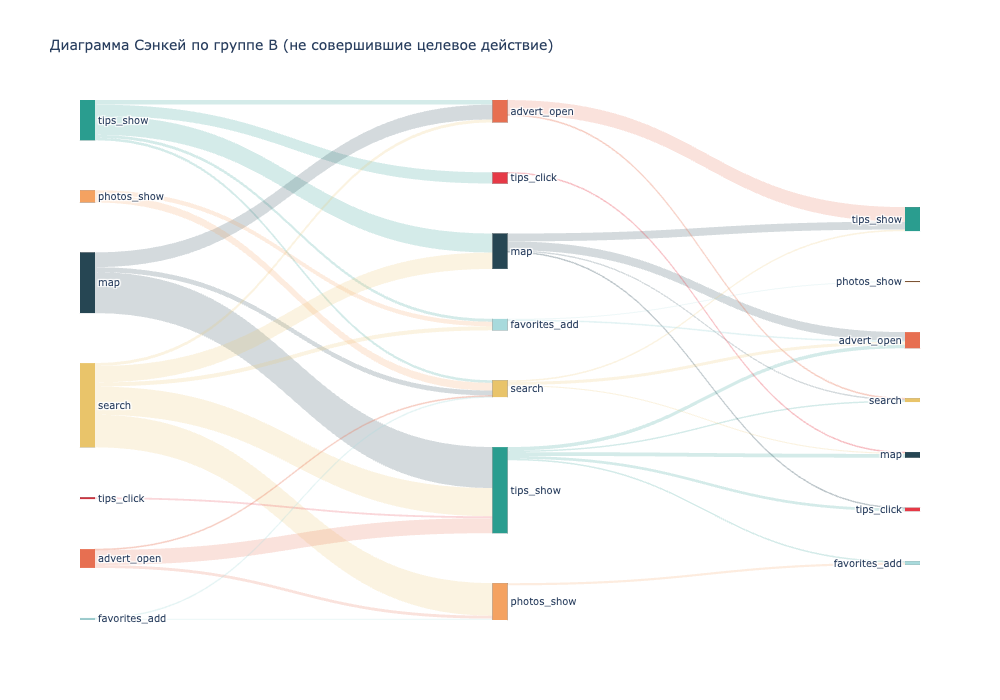

It can be seen that in Group B, scenarios most often start with **search** or **map**, followed by **tips_show**.  
Another common path is from **tips_show** back to **map**.  
The **map** action appears more frequently in the scenarios of users who did not perform the contact action.

#### Scenario funnels

**Scenario 1:** tips_show → show_contacts

In [136]:
step_one = df[df['event_name'] == "tips_show"]['user_id']
a = step_one.nunique()
step_two = df.query('user_id in @step_one and event_name == "show_contacts"')['user_id']
b = step_two.nunique()
#step_three = df.query('user_id in @step_two and event_name == "show_contact"')['user_id']
#c = step_three.nunique()

In [137]:
table = [['tips_show', a], ['show_contacts', b]]

In [138]:
table = pd.DataFrame(table).set_axis(['phases', 'values'], axis=1)

In [140]:
fig = go.Figure(go.Funnel(
    x = table['values'],
    y = table['phases'], 
    textposition = "inside",
    textinfo = "value+percent previous",
    opacity = 0.65, marker = {"color": px.colors.sequential.RdBu,
    "line": {"width": [4, 2, 2, 3, 1, 1], "color": "azure"}}
    ))
fig.update_traces(textfont_color='white')
fig.update_layout(
    title={
        'text': "Funnel for Scenario 1",
        'y':0.9,
        'x':0.54,
        'xanchor': 'center',
        'yanchor': 'top'}) 
fig.show()

**Conclusion:**

1. In Scenario 1, the conversion to the target action is **18%**.

**Scenario 2:** map → tips_show → show_contacts

In [141]:
step_one = df[df['event_name'] == "map"]['user_id']
a = step_one.nunique()
step_two = df.query('user_id in @step_one and event_name == "tips_show"')['user_id']
b = step_two.nunique()
step_three = df.query('user_id in @step_two and event_name == "show_contacts"')['user_id']
c = step_three.nunique()

In [142]:
table = [['map', a], ['tips_show', b] , ['show_contacts', c]]

In [143]:
table = pd.DataFrame(table).set_axis(['phases', 'values'], axis=1)
table

phases  values
0            map    1456
1      tips_show    1352
2  show_contacts     275

In [145]:
fig = go.Figure(go.Funnel(
    x = table['values'],
    y = table['phases'], 
    textposition = "inside",
    textinfo = "value+percent previous",
    opacity = 0.65, marker = {"color": px.colors.sequential.RdBu,
    "line": {"width": [4, 2, 2, 3, 1, 1], "color": "azure"}}
    ))
fig.update_traces(textfont_color='white')
fig.update_layout(
    title={
        'text': "Funnel for Scenario 2",
        'y':0.9,
        'x':0.54,
        'xanchor': 'center',
        'yanchor': 'top'}) 
fig.show()

**Conclusion:**

1. In Scenario 2, the share of unique users moving from **map** to **tips_show** is **93%** — almost everyone who viewed the map saw recommendations.  
2. Conversion from **tips_show** to **show_contacts** is **20%**, which is nearly the same as in the scenario where the map was not viewed.  
3. Recommendations are often displayed in the map section, but this does not increase conversion. It can be assumed that although recommendations appear on the map, they are not relevant to the user’s query.

**Scenario 3:** search --> photos_show --> show_contacts

In [146]:
step_one = df[df['event_name'] == "search"]['user_id']
a = step_one.nunique()
step_two = df.query('user_id in @step_one and event_name == "photos_show"')['user_id']
b = step_two.nunique()
step_three = df.query('user_id in @step_two and event_name == "show_contacts"')['user_id']
c = step_three.nunique()

In [147]:
table = [['search', a], ['photos_show', b] , ['show_contacts', c]]

In [148]:
table = pd.DataFrame(table).set_axis(['phases', 'values'], axis=1)
table

phases  values
0         search    1666
1    photos_show     647
2  show_contacts     192

In [150]:
fig = go.Figure(go.Funnel(
    x = table['values'],
    y = table['phases'], 
    textposition = "inside",
    textinfo = "value+percent previous",
    opacity = 0.65, marker = {"color": px.colors.sequential.RdBu,
    "line": {"width": [4, 2, 2, 3, 1, 1], "color": "azure"}}
    ))
fig.update_traces(textfont_color='white')
fig.update_layout(
    title={
        'text': "Funnel for Scenario 3",
        'y':0.9,
        'x':0.54,
        'xanchor': 'center',
        'yanchor': 'top'}) 
fig.show()

**Conclusion:**

1. Transition from **search** to **photos_show** — **39%** of unique users.  
2. Transition from **photos_show** to **show_contacts** — **30%** of users.  
3. Compared to Scenarios 1 and 2, the conversion in **Scenario 3** is higher by **10%**.

**Scenario 4:** search --> tips_show --> show_contacts (дополнительный)

In [151]:
step_one = df[df['event_name'] == "search"]['user_id']
a = step_one.nunique()
step_two = df.query('user_id in @step_one and event_name == "tips_show"')['user_id']
b = step_two.nunique()
step_three = df.query('user_id in @step_two and event_name == "show_contacts"')['user_id']
c = step_three.nunique()

In [152]:
table = [['search', a], ['tips_show', b] , ['show_contacts', c]]

In [153]:
table = pd.DataFrame(table).set_axis(['phases', 'values'], axis=1)
table

phases  values
0         search    1666
1      tips_show     801
2  show_contacts     139

In [155]:
fig = go.Figure(go.Funnel(
    x = table['values'],
    y = table['phases'], 
    textposition = "inside",
    textinfo = "value+percent previous",
    opacity = 0.65, marker = {"color": px.colors.sequential.RdBu,
    "line": {"width": [4, 2, 2, 3, 1, 1], "color": "azure"}}
    ))
fig.update_traces(textfont_color='white')
fig.update_layout(
    title={
        'text': "Funnel for Scenario 4",
        'y':0.9,
        'x':0.54,
        'xanchor': 'center',
        'yanchor': 'top'}) 
fig.show()

**Conclusion:**

1. Transition from **search** to **tips_show** — **48%** of unique users.  
2. Transition from **tips_show** to **show_contacts** — **17%**.  
3. Based on Scenarios 3 and 4, it can be concluded that **viewing photos converts users better (by +13%)** than viewing recommendations (**tips_show**).

#### Event frequency analysis by groups

It is necessary to calculate the relative frequency of events across two user groups:

○ Group A — users who viewed contacts (**show_contacts**)  
○ Group B — users who did not view contacts (**show_contacts**)

In [156]:
data = df.merge(scenario[['show_contact_flg','session_id']], on='session_id')
data = data.merge(df_sources, on='user_id')

In [157]:
data.head(2)

event_time   event_name                               user_id  time_diff  \
0 2019-10-07  advert_open  020292ab-89bc-4156-9acf-68bc2783f894        0.0   
1 2019-10-07  advert_open  020292ab-89bc-4156-9acf-68bc2783f894        0.0   

   session_id session_start         session_end  session_dur  session_year  \
0          82    2019-10-07 2019-10-07 00:18:42         18.7          2019   
1          82    2019-10-07 2019-10-07 00:18:42         18.7          2019   

   session_month  session_week session_date  show_contact_flg source  
0             10            41   2019-10-07             False  other  
1             10            41   2019-10-07             False  other

In [158]:
# calculating the percentage of action categories
# exclude contact views for group A, since it is the target and distinguishing action
# exclude contact calls, as this is also specific to group A
# focus only on actions common to both groups
# exclude tips_show, since it does not represent an active user action

event_stat_a = (
    data[
        (data['show_contact_flg'] == True) &
        (data['event_name'] != "tips_show") &
        (data['event_name'] != "contacts_call") &
        (data['event_name'] != "show_contacts")
    ]['event_name']
    .value_counts()
    .reset_index()
)

event_stat_b = data.query('show_contact_flg == False and event_name != "tips_show"')['event_name'].value_counts().reset_index()

# calculate total events per group
event_stat_a['total'] = event_stat_a['event_name'].sum()
event_stat_b['total'] = event_stat_b['event_name'].sum()

# calculate relative frequency
event_stat_a['group_percent'] = round(event_stat_a['event_name'] / event_stat_a['total'], 2)
event_stat_b['group_percent'] = round(event_stat_b['event_name'] / event_stat_b['total'], 2)

# events.head(2)

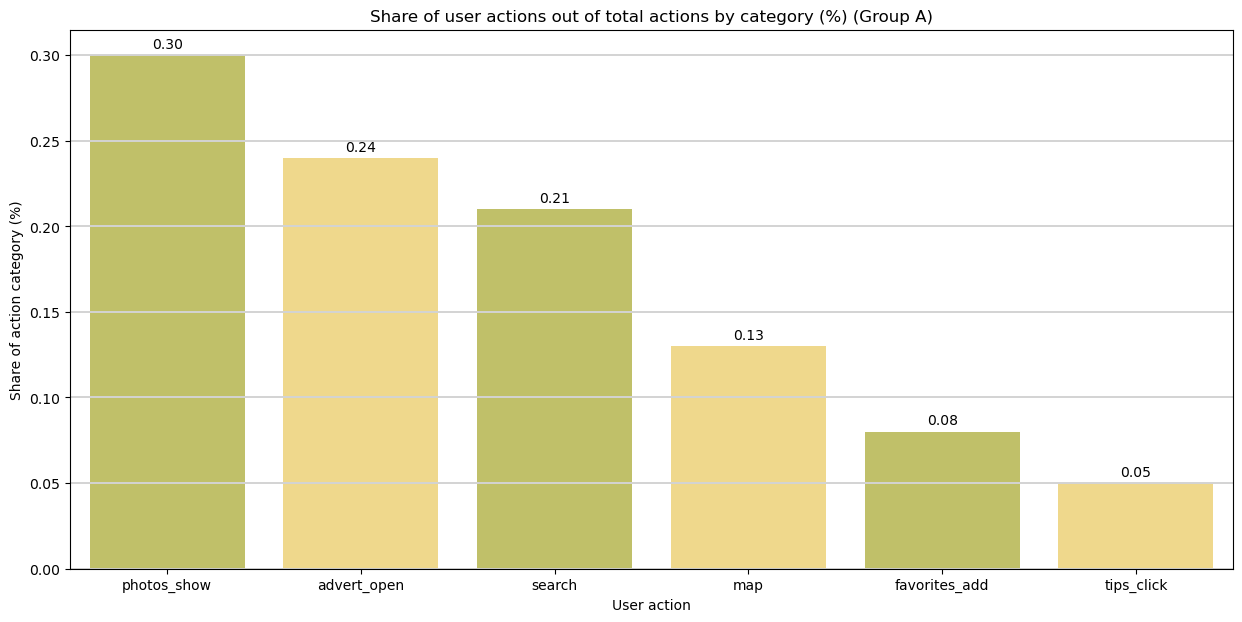

In [159]:
fig, ax = plt.subplots(figsize=(15, 7))
fig.patch.set_facecolor('xkcd:white')  # set figure background to white
ax.set_facecolor("white")
plt.grid(True, color="lightgrey", linewidth=1.4, linestyle="-")

plots = sns.barplot(data=event_stat_a, x='index', y='group_percent', palette=colors, ax=ax)

for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.2f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()),
                   ha='center', va='center',
                   size=10, xytext=(0, 8),
                   textcoords='offset points')

ax.set(xlabel='User action', ylabel='Share of action category (%)')
plt.title('Share of user actions out of total actions by category (%) (Group A)')
plt.show()

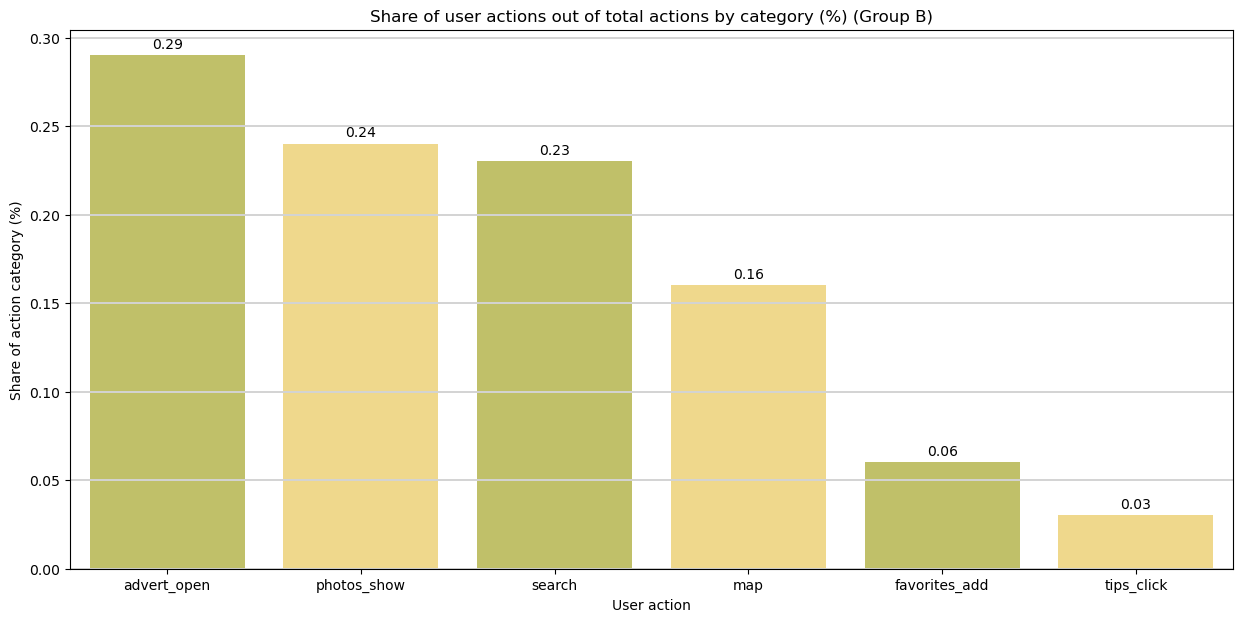

In [160]:
fig, ax = plt.subplots(figsize=(15, 7))
fig.patch.set_facecolor('xkcd:white')  # set figure background to white
ax.set_facecolor("white")
plt.grid(True, color="lightgrey", linewidth=1.4, linestyle="-")

plots = sns.barplot(data=event_stat_b, x='index', y='group_percent', palette=colors, ax=ax)

for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.2f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()),
                   ha='center', va='center',
                   size=10, xytext=(0, 8),
                   textcoords='offset points')

ax.set(xlabel='User action', ylabel='Share of action category (%)')
plt.title('Share of user actions out of total actions by category (%) (Group B)')
plt.show()

**Conclusion:**

1. Difference in the share of **search** between Group A and Group B: **-2%**  
2. Difference in the share of **photo views (A–B): +6%**  
3. Difference in the share of **map opens (A–B): -3%**  
4. Difference in the share of **ad opens (A–B): -5%**  
5. Difference in the share of **favorites added (A–B): +2%**  
6. Difference in the share of **ad clicks (A–B): +2%**  

The main difference is that **Group A views photos 6 percentage points more often**, and as shown earlier, this action strongly impacts conversion.  
Meanwhile, **Group B opens ads 5 percentage points more often** (possibly ads without photos).

#### Section conclusion:

1. As a share of total actions, users rarely click on recommendations — **1%**.  

2. Users perform the contact view action in **13%** of cases.  

3. Sessions with only one action were excluded, since such scenarios do not reveal behavioral patterns in either group.  

4. Scenarios were selected based on two criteria:  
   * **Popularity** — top-10 by frequency across sessions  
   * **Validity** — scenario ends with the target action  

5. The following scenarios were used for funnel analysis:  
   * **Scenario 1: tips_show → show_contact** — cannot be discarded due to its large share, even though it does not fully reflect a behavioral pattern.  
   * **Scenario 2: map → tips_show → show_contact** — shows a clear behavioral pattern and has sufficient repetitions.  
   * **Scenario 3: search → photos_show → show_contact**  
   * **Scenario 4: search → tips_show → show_contact** — included for comparison with Scenario 3.  

6. Together, these scenarios cover about **50% of all filtered scenarios** (filter: only sessions ending with the target action were kept).  

7. Conversion from **tips_show** to **show_contacts** is **20%** in Scenario 2, nearly the same as in Scenario 1, where the map was not viewed.  
   * Recommendations are often displayed in the map section, but this does not increase conversion, likely because they are not relevant to the user’s query.  

8. Compared to Scenarios 1 and 2, **Scenario 3 shows a 10% higher conversion**.  

9. Based on Scenarios 3 and 4, it can be concluded that **after search, photo viewing converts users better (+13%) than recommendations (tips_show)**.  

10. Overall, the conversion from **photos_show** to **show_contacts** is very high — around **90%**.  

11. The **map** action appears more frequently in the scenarios of users who did not perform the contact view.  

12. The main behavioral difference between **Group A** (contact viewers) and **Group B** (non-viewers) is that Group A views **photos 6 percentage points more often**, which is strongly linked to higher conversion. Meanwhile, Group B opens **ads 5 percentage points more often** (possibly ads without photos).

### Cohort analysis and user metrics

For the cohort analysis, an **assumption was made that all unique users are new users**.

#### Functions for calculating metrics and plotting graphs

In [161]:
def get_profiles(sessions, event_names=[]):
    # sort sessions by user ID and acquisition date
    # group by user ID and get parameters of first visits

    profiles = (
        data
        .sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg({'session_start': 'first', 'source': 'first'})
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # for cohort analysis: define the date of first visit
    # and the first day of the month in which this visit occurred
    profiles['dt'] = pd.to_datetime(profiles['first_ts']).dt.normalize()
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # add flag for users who performed the target action
    conversed_users = df.query('event_name == "show_contacts"')['user_id']
    profiles['contact_flg'] = profiles['user_id'].isin(conversed_users)

    # calculate number of unique users by acquisition date and source
    new_users = (
        profiles.groupby(['dt', 'source'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})  # column for user count
        .reset_index()
    )
    new_users['dt'] = pd.to_datetime(new_users['dt']).dt.normalize()
    
    # return profiles with CAC features
    return profiles

In [162]:
def get_conversion(
    profiles,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):
    # exclude users who didn't "survive" to the analysis horizon
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # define the first time the target action was performed per user
    first_contact_show = (
        data[data['event_name'] == "show_contacts"]
        .sort_values(by=['user_id', 'event_time'])
        .groupby('user_id')
        .agg({'event_time': 'first'})
        .reset_index()
    )

    # merge target-action timestamps into profiles
    result_raw = result_raw.merge(
        first_contact_show[['user_id', 'event_time']], on='user_id', how='left'
    )

    # compute lifetime (days) to the first target action
    result_raw['lifetime'] = (
        result_raw['event_time'] - result_raw['first_ts']
    ).dt.days

    # if no dimensions provided, use a single cohort
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # helper: group by chosen dimensions and build a conversion triangle
    def group_by_dimensions(df, dims, horizon_days):
        # build triangle table: lifetime (columns) vs dims (rows)
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        # cumulative sum over lifetimes
        result = result.fillna(0).cumsum(axis=1)
        # cohort sizes
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # attach cohort sizes
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # convert counts to rates
        result = result.div(result['cohort_size'], axis=0)
        # keep lifetimes within horizon
        result = result[['cohort_size'] + list(range(horizon_days))]
        # restore cohort sizes (series → column)
        result['cohort_size'] = cohort_sizes
        return result

    # conversion by cohorts/dimensions
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # for time dynamics, drop 'cohort' if it was injected above
    if 'cohort' in dimensions:
        dimensions = []

    # conversion dynamics by acquisition date
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # return raw joined data, grouped conversion, and time dynamics
    return result_raw, result_grouped, result_in_time

In [163]:
def get_retention(profiles, sessions, observation_date, horizon_days, dimensions = [], ignore_horizon = False):
    # decide which columns to keep for retention grouping; contact_flg stays always
    dimensions = ['contact_flg'] + dimensions
    
    # cut off users who couldn't "survive" to the horizon (joined later than observation_date - horizon)
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(days=horizon_days - 1)
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # build raw dataset
    result_raw = result_raw.merge(sessions[['user_id', 'session_start']], on='user_id', how='left')
    result_raw['lifetime'] = (result_raw['session_start'] - result_raw['first_ts']).dt.days
    
    # helper to group by chosen dimensions
    def group_by_dimensions(df, dims, horizon_days):
        # build "triangle" table
        result = df.pivot_table(index=dims, columns='lifetime', values='user_id', aggfunc='nunique')
        # compute cohort sizes
        cohort_sizes = (
            df.groupby(dims)
              .agg({'user_id': 'nunique'})
              .rename(columns={'user_id': 'cohort_size'})
        )
        # attach cohort sizes to the triangle
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # convert counts to retention rate
        result = result.div(result['cohort_size'], axis=0)
        # keep only within horizon and the cohort_size column
        result = result[['cohort_size'] + list(range(horizon_days))]
        # restore cohort_size (it became 1.0 after division)
        result['cohort_size'] = cohort_sizes
        return result
    
    # compute retention by groups
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)
    
    # compute retention by groups over time
    result_in_time = group_by_dimensions(result_raw, dimensions + ['dt'], horizon_days)
    
    # return raw data and both retention tables
    return result_raw, result_grouped, result_in_time

In [164]:
def filter_data(df, window):
    # apply moving average for each column
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean()
    return df

# window = 7
# filter_data(report, window).plot(grid=True)
# plt.title('Smoothing window width: {}'.format(window))
# plt.xlabel('Acquisition date')
# plt.show()

In [165]:
def plot_conversion(conversion, conversion_history, horizon, window=7):
    # set figure size
    plt.figure(figsize=(15, 5))

    # drop cohort size
    conversion = conversion.drop(columns=['cohort_size'])
    # in conversion history keep only the desired lifetime
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # first plot — conversion curves
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Lifetime')
    plt.title('User conversion')

    # second plot — conversion dynamics
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # columns of the pivot table = all index columns except date
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Acquisition date')
    plt.title('User conversion dynamics on day {}'.format(horizon))

    plt.tight_layout()
    plt.show()

In [166]:
def plot_retention(retention, retention_history, horizon, window=7):
    # set figure size
    plt.figure(figsize=(15, 10))

    # drop cohort sizes and day-0 retention
    retention = retention.drop(columns=['cohort_size', 0])
    # in the dynamics table keep only the required lifetime
    retention_history = retention_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # if retention index has only the action-flag, add a cohort label
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'contact_flg'])

    # 2×2 grid of plots
    # top-left: retention curves for users who viewed contacts
    ax1 = plt.subplot(2, 2, 1)
    retention.query('contact_flg == True').droplevel('contact_flg').T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Lifetime')
    plt.title('Retention — users who viewed contacts')

    # top-right: retention curves for users who did not view contacts (share y-axis with left)
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('contact_flg == False').droplevel('contact_flg').T.plot(grid=True, ax=ax2)
    plt.legend()
    plt.xlabel('Lifetime')
    plt.title('Retention — users who did not view contacts')

    # bottom-left: retention dynamics for users who viewed contacts
    ax3 = plt.subplot(2, 2, 3)
    # columns for the pivot (all index names except date and deprecated 'payer')
    columns = [name for name in retention_history.index.names if name not in ['dt', 'payer']]
    filtered_data = retention_history.query('contact_flg == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Acquisition date')
    plt.title(f'Retention dynamics — viewed contacts on day {horizon}')

    # bottom-right: retention dynamics for users who did not view contacts (share y with bottom-left)
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    filtered_data = retention_history.query('contact_flg == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Acquisition date')
    plt.title(f'Retention dynamics — did not view contacts on day {horizon}')

    plt.tight_layout()
    plt.show()

#### Metrics analysis

In [167]:
# checking available event horizon
data['event_time'].max()-data['event_time'].min()

Timedelta('27 days 23:58:12')

In [170]:
print('Earliest event date:',
    data['event_time'].min()
)

Earliest event date: 2019-10-07 00:00:00


In [169]:
print('Latest event date:',
    data['event_time'].max()
)

Latest event date: 2019-11-03 23:58:12


#### Engagement metrics

● **Conversion** — the share of new users who performed the target action (**show_contacts**).

In [171]:
# getting user profiles
users = get_profiles(data)

pd.DataFrame(users.head(5)).query('contact_flg == True').sort_values(by='dt')

user_id            first_ts  source  \
1  00157779-810c-4498-9e05-a1e9e3cedf93 2019-10-19 21:34:33  yandex   
4  00551e79-152e-4441-9cf7-565d7eb04090 2019-10-25 16:44:41  yandex   

          dt               month  contact_flg  
1 2019-10-19 2019-10-19 21:34:33         True  
4 2019-10-25 2019-10-25 16:44:41         True

In [172]:
conversion_raw, conversion_reg, conversion_reg_history = get_conversion(
    users, datetime(2019, 11, 1).date(), 14, dimensions=[]
)

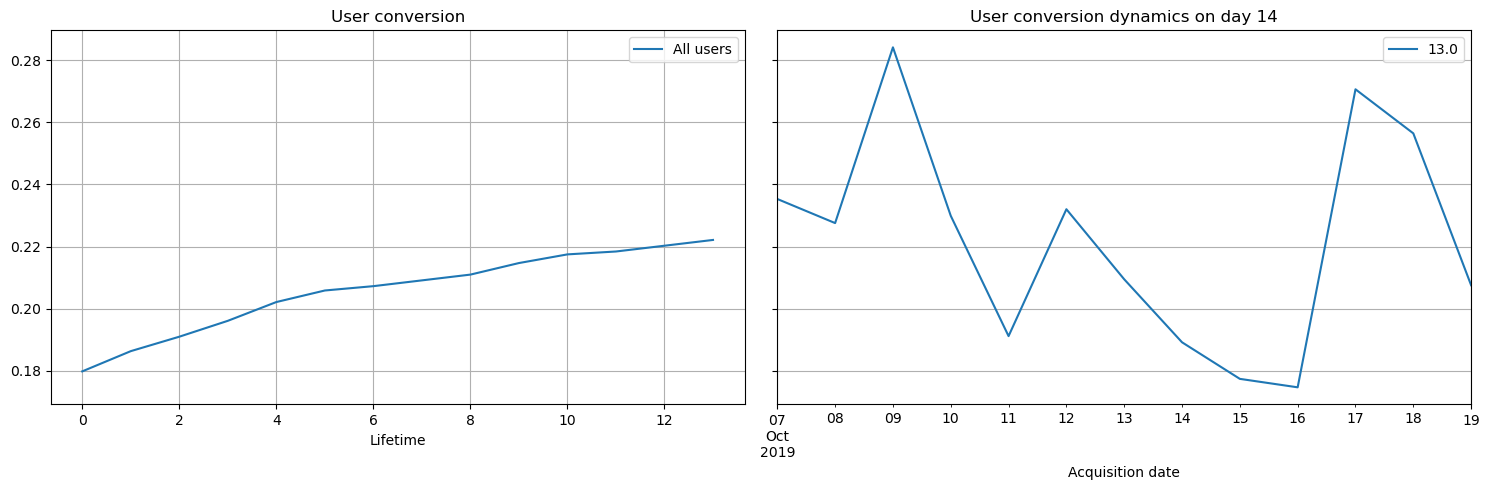

In [173]:
plot_conversion(conversion_reg, conversion_reg_history, 14, window=1)

**Conclusion:**

1. Conversion over a 14-day horizon grows steadily from **18% on day 1** to **23%**.  
2. In dynamics, the 14-day conversion rate across the monthly data shows two clear peaks — **October 9** and **October 17** — with an additional smaller peak on **October 12**.  
   *The first peak may be explained by an increase in users — more ads were added, a new app update was released, or additional photos were uploaded.*

#### Satisfaction metrics

● **Retention Rate** — measures how actively users continue to use the product.

In [175]:
# calling the function
retention_raw, retention, retention_history = get_retention(
    users, data, datetime(2019, 11, 1).date(), 14
)

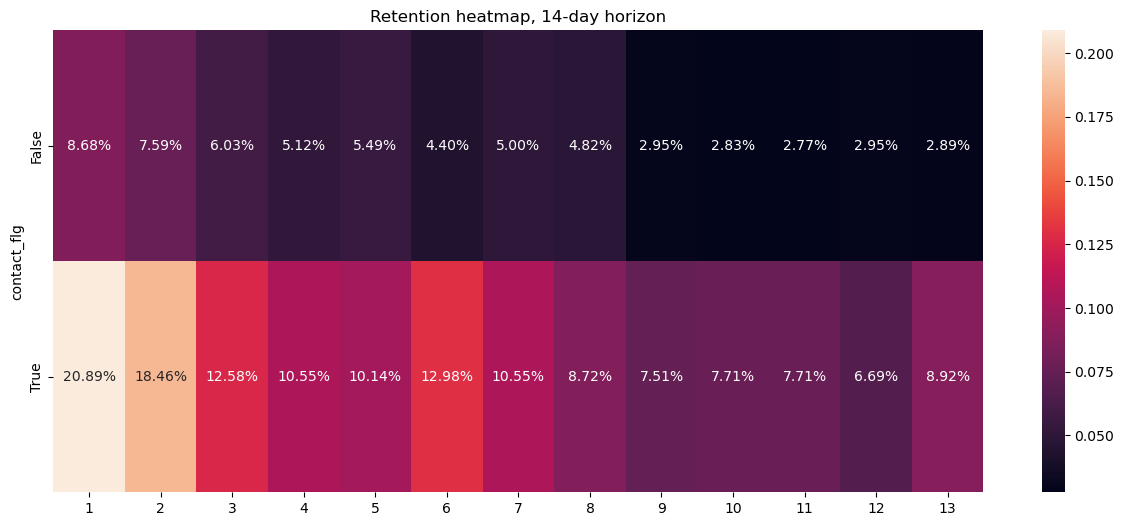

In [176]:
plt.figure(figsize=(15, 6))  # set figure size
sns.heatmap(
    retention.drop(columns=['cohort_size', 0]),  # drop cohort sizes
    annot=True,  # show labels
    fmt='.2%',  # format values as percentages
)
plt.title('Retention heatmap, 14-day horizon')  # chart title
plt.show()

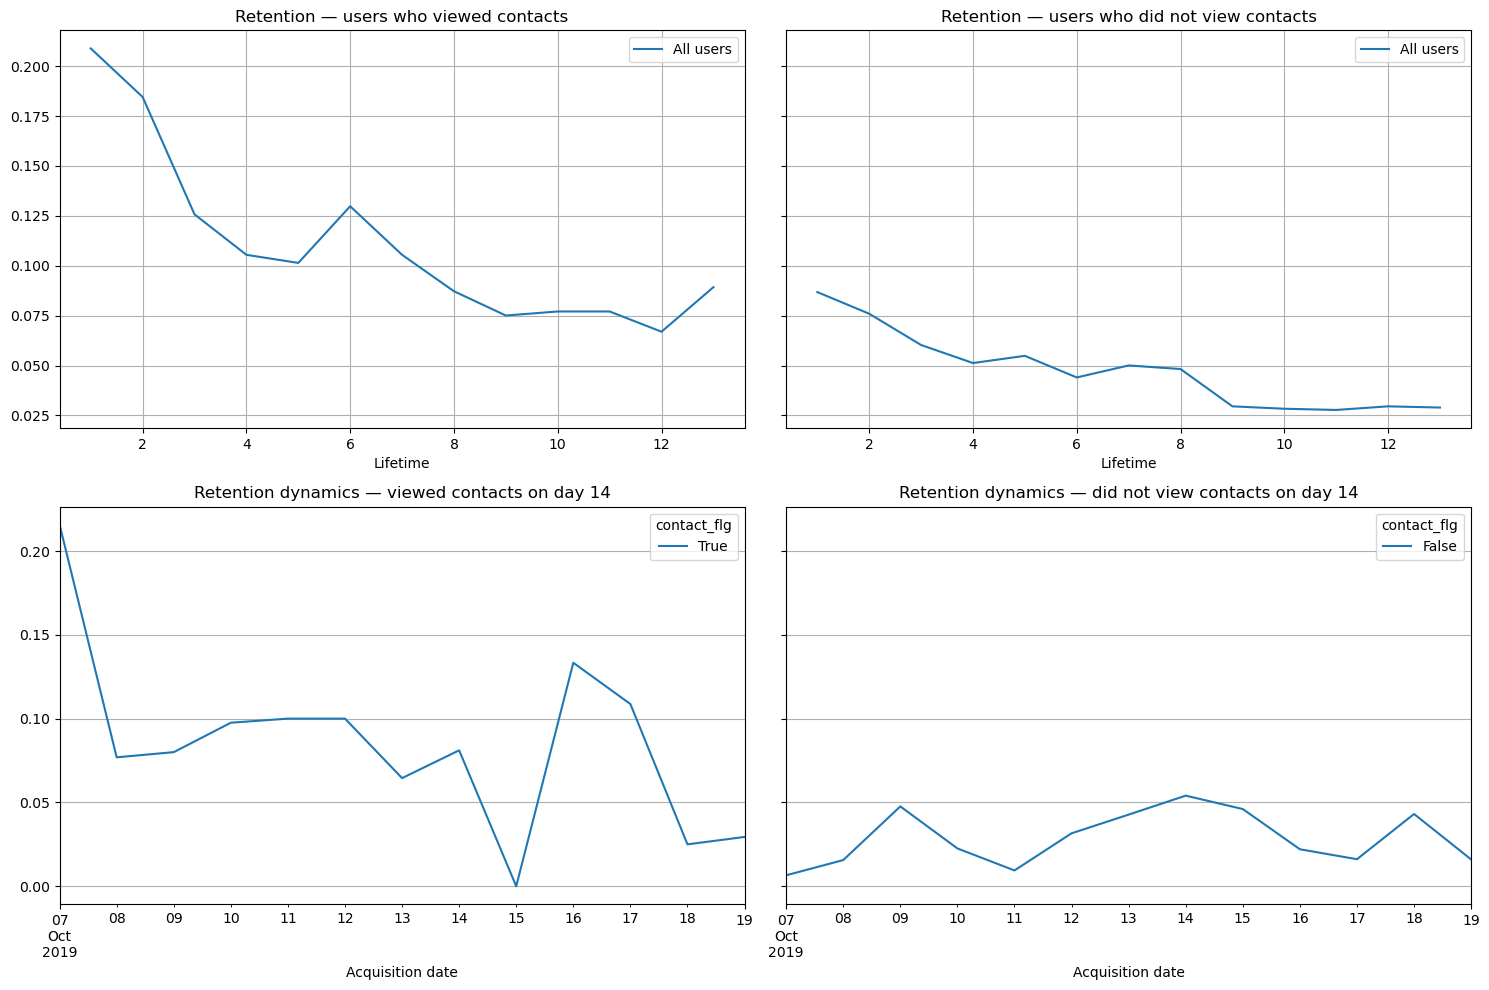

In [177]:
plot_retention(retention,retention_history, 14, window=1);

**Conclusion:**

1. Users who performed the target action have a higher **Retention Rate (RR)** on average.  
2. For non-converted users, RR decreases steadily by **1–2% per day** of app usage.  
3. Converted users show higher RR at the **3rd** and **6th** days over the 14-day horizon.  
4. For converted users, RR also declines unevenly. Given the assumption that the app is new and the dataset covers only one month, the data may be highly volatile.  
5. In dynamics, the **14-day RR** for converted users dropped by nearly **100% on October 15**.

#### Audience metrics

● **DAU, WAU, MAU** — the number of unique users who used the product within a **day**, a **week**, and a **month**.

In [178]:
dau_total = (
    df.groupby('session_date').agg({'user_id': 'nunique'}).mean()
)

wau_total = (
    df.groupby(['session_year', 'session_week'])
    .agg({'user_id': 'nunique'})
    .mean()
)

mau_total = (
    df.groupby(['session_year', 'session_month'])
    .agg({'user_id': 'nunique'})
    .mean()
) 

print('DAU:',int(dau_total))
print('WAU:',int(wau_total)) 
print('MAU:',int(mau_total)) 

DAU: 278
WAU: 1381
MAU: 2307


● **Sticky factor** — reflects the regularity of app usage.

In [179]:
sticky_wau = dau_total / wau_total * 100
sticky_mau = dau_total / mau_total * 100

print('sticky factor (week):', int(sticky_wau))
print('sticky factor (month):', int(sticky_mau))

sticky factor (week): 20
sticky factor (month): 12


● **Shares of events using different service features**

In [180]:
print('Share of "favorites_add" events:',
    round(
        len(df.query('event_name == "favorites_add"')) / len(df),
    2)
)

Share of "favorites_add" events: 0.02


In [181]:
print('Share of "map" events:',
    round(
        len(df.query('event_name == "map"')) / len(df),
    2)
)

Share of "map" events: 0.05


#### Performance metrics

● **Session duration**

To calculate this metric, we first need to remove outliers in session duration.

In [182]:
df_temp = (df[['session_id','session_dur','user_id']]
           .drop_duplicates(subset=['session_id','user_id'])
           .sort_values(by='session_id')
          )
df_temp['session_dur'].describe()

count    11537.000000
mean         9.440857
std         14.186407
min          0.000000
25%          0.083333
50%          4.316667
75%         13.050000
max        233.650000
Name: session_dur, dtype: float64

In [183]:
len(df_temp) == df_temp['session_id'].max()

True

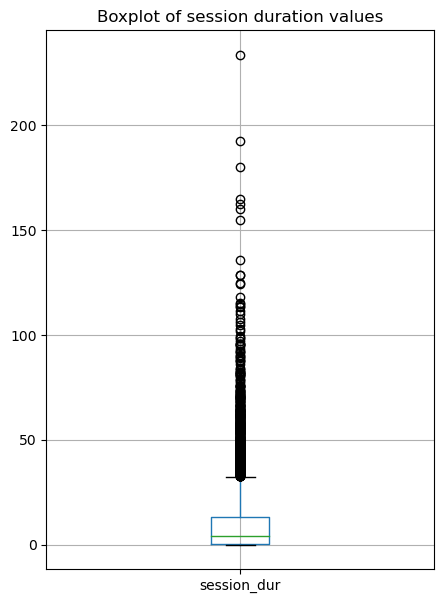

In [184]:
# checking the distribution of session duration
fig = plt.figure(figsize=(5, 7))
plt.title('Boxplot of session duration values')
df_temp.boxplot('session_dur')
plt.show()

In [185]:
q3, q1 = np.percentile(df_temp['session_dur'], [75 ,25])
iqr = q3 - q1
upper_outl = q3+iqr
lower_outl = q1-iqr

In [186]:
# filtering outliers below and above IQR
df_filtred = df_temp[
    (df_temp['session_dur'] < upper_outl) & 
    (df_temp['session_dur'] > lower_outl)
]

In [187]:
print(
    'Average session duration (minutes):',
    int(df_filtred['session_dur'].mean())
)

Average session duration (minutes): 5


**Average number of sessions per user per day**

In [190]:
print('Average number of sessions per user per day:',
    round(
        df_filtred['session_id'].nunique() /
        df_filtred['user_id'].nunique() /
        df['session_date'].nunique(),
    2)
)

Average number of sessions per user per day: 0.09


**Relationship between the target action and the app installation source**

In [192]:
data = df.merge(df_sources, on='user_id')

In [193]:
source_data = data[data['event_name'] == 'show_contacts']['source'].value_counts().reset_index()
source_data['total'] = source_data['source'].sum()
source_data['group_percent'] = source_data['source']/source_data['total']

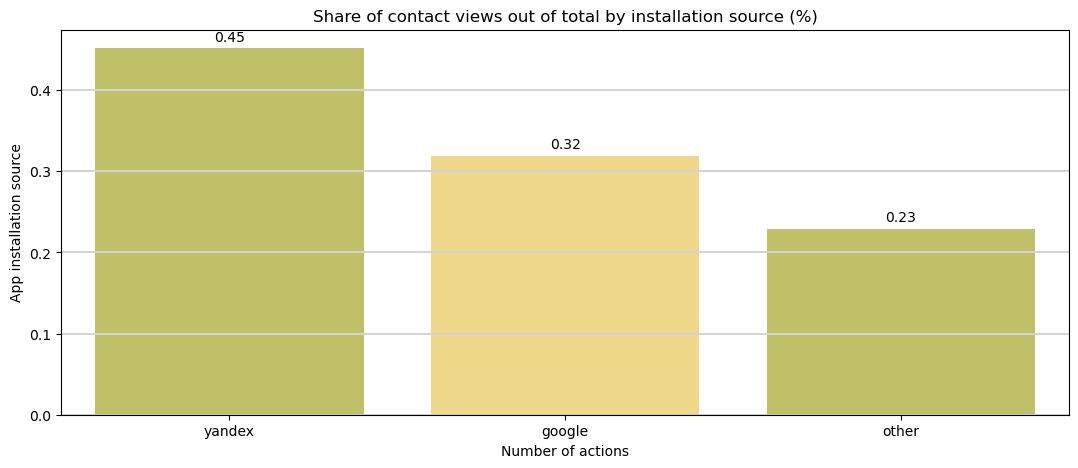

In [194]:
fig, ax = plt.subplots(figsize=(13, 5))
fig.patch.set_facecolor('xkcd:white') # This changes the grey to white
ax.set_facecolor("white")
plt.grid(True, color = "lightgrey", linewidth = "1.4", linestyle = "-")
        
plots = sns.barplot(data = source_data, x = 'index', y = 'group_percent', palette=colors, ax=ax)

for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.2f'), 
                   (bar.get_x() + bar.get_width() / 2, 
                    bar.get_height()), ha='center', va='center',
                   size=10, xytext=(0, 8),
                   textcoords='offset points')


ax.set(xlabel='Number of actions', ylabel='App installation source')
plt.title('Share of contact views out of total by installation source (%)')
plt.show()

**Conclusion:**

1. The share of contact views among users who installed the app from **Yandex** is **10% higher** than among those from **Google**.

#### Section conclusion:

**Final conclusions:**

1. Conversion over a 14-day horizon grows steadily from **18% on day 1** to **23%**.  

2. The 14-day conversion dynamics over the month show two clear peaks (**October 9** and **October 17**) and one smaller peak (**October 12**). The first peak may be linked to a user increase — more ads added, an app update released, or new photos uploaded.  

3. **Retention Rate (RR)** is on average higher among users who performed the target action.  

4. For non-converted users, RR declines steadily by **1–2% per day** of app use.  

5. For converted users, RR drops unevenly. Given the assumption that the app is new and the dataset spans only one month, the data may be highly volatile.  

6. The 14-day RR for converted users dropped by nearly **100% on October 15**.  

7. **DAU:** 278, **WAU:** 1381, **MAU:** 2307.  

8. **Sticky factor** — week: **20**, month: **12**.  

9. Share of users using **favorites_add:** **2%**. Share of users using **map:** **5%**.  

10. Average session duration: **5 minutes**. Average number of sessions per user per day: **0.09**.  

11. The share of contact views among users who installed the app via **Yandex** is **10% higher** than among those from **Google**.

### Statistical data analysis

Hypothesis testing using a statistical test:

1) **Null hypothesis (H₀):** The group of users who perform **tips_click + tips_show** has the same conversion rate as the group of users who perform only **tips_show**.  

   **Alternative hypothesis (H₁):** The conversion rates of Group 1 and Group 2 are different.

In [195]:
data_stat = data.merge(scenario[['show_contact_flg','session_id']], on='session_id')
# data_stat = data_stat[['event_name','user_id','show_contact_flg','source']]

# create dataset only with recommendation events
tips_stat = (
    data_stat
    .drop_duplicates(subset=['user_id', 'event_name'])
    .query('event_name in ["tips_click", "tips_show"]')
    [['event_name', 'show_contact_flg', 'user_id']]
)

tips_stat

event_name  show_contact_flg                               user_id
3        tips_show             False  020292ab-89bc-4156-9acf-68bc2783f894
84       tips_show             False  cf7eda61-9349-469f-ac27-e5b6f5ec475c
153     tips_click             False  cf7eda61-9349-469f-ac27-e5b6f5ec475c
364      tips_show              True  8c356c42-3ba9-4cb6-80b8-3f868d0192c3
394     tips_click              True  8c356c42-3ba9-4cb6-80b8-3f868d0192c3
...            ...               ...                                   ...
158729   tips_show             False  89235e36-99e2-4c33-afd8-919b522b6614
158747   tips_show             False  424c0ae1-3ea3-4f1e-a814-6bac73e48ab1
158752   tips_show             False  437a4cd4-9ba9-457f-8614-d142bc48fbeb
158758  tips_click              True  c10055f0-0b47-477a-869e-d391b31fdf8f
158772   tips_show             False  d157bffc-264d-4464-8220-1cc0c42f43a9

[3123 rows x 3 columns]

In [196]:
# warning: quick-and-dirty workaround
# create event sequences for tips per user
a = tips_stat.groupby('user_id')['event_name'].sum().reset_index()

# merge two sequences of actions into one
a['event_name'] = a['event_name'].replace('tips_clicktips_show', 'tips_showtips_click')

# remove users who only clicked
a = a.query('event_name != "tips_click"')

In [197]:
# select all users who performed the target action
true_users = tips_stat[tips_stat['show_contact_flg'] == True]['user_id']

In [198]:
# trials — all users by groups 1 and 2
trials_for_test = a.groupby('event_name')['user_id'].nunique()

# successes — users who performed the target action in groups 1 and 2
success_for_test = (
    a.query('user_id in @true_users')
     .groupby('event_name')['user_id'].nunique()
)

In [199]:
np.array(trials_for_test), np.array(success_for_test)

(array([2504,  297]), array([279,  63]))

In [200]:
alpha = .05  # significance level

successes = np.array(success_for_test)
trials = np.array(trials_for_test)

# success rate in group 1
p1 = successes[0] / trials[0]

# success rate in group 2
p2 = successes[1] / trials[1]

# combined success rate
p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

# difference in proportions
difference = p1 - p2

# compute z-statistic (in standard deviations of normal distribution)
z_value = difference / mth.sqrt(
    p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1])
)

# standard normal distribution (mean 0, std 1)
distr = st.norm(0, 1)

# two-tailed p-value
p_value = (1 - distr.cdf(abs(z_value))) * 2

print('p-value:', p_value)

if p_value < alpha:
    print('Reject the null hypothesis: significant difference between proportions')
else:
    print('Fail to reject the null hypothesis: no evidence that proportions differ')

p-value: 5.394539546177413e-07
Reject the null hypothesis: significant difference between proportions


2) **Null hypothesis (H₀):** The group of users with session source **Yandex** has the same conversion rate as the group with session source **Google**.  

   **Alternative hypothesis (H₁):** The conversion rates of the two groups are different.

In [202]:
source_stat = data_stat[['user_id','show_contact_flg','source']]
true_users = source_stat[source_stat['show_contact_flg'] == True]['user_id']
yandex = source_stat[source_stat['source'] == "yandex"]
google = source_stat[source_stat['source'] == "google"]

In [203]:
trials_for_test_y = yandex['user_id'].nunique()
trials_for_test_g = google['user_id'].nunique()

In [204]:
success_for_test_y = yandex.query('user_id in @true_users')['user_id'].nunique()
success_for_test_g = google.query('user_id in @true_users')['user_id'].nunique()

In [205]:
trials_for_test_y,trials_for_test_g,success_for_test_y,success_for_test_g

(1934, 1129, 478, 275)

In [206]:
successes = np.array([success_for_test_y,success_for_test_g])
#trials = np.array(trials_for_test_y)

In [207]:
alpha = .01  # significance level

successes = np.array([success_for_test_y, success_for_test_g])
trials = np.array([trials_for_test_y, trials_for_test_g])

# success rate in group 1 (Yandex)
p1 = successes[0] / trials[0]

# success rate in group 2 (Google)
p2 = successes[1] / trials[1]

# combined success rate
p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

# difference in proportions
difference = p1 - p2

# compute z-statistic
z_value = difference / mth.sqrt(
    p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1])
)

# standard normal distribution (mean 0, std 1)
distr = st.norm(0, 1)

# two-tailed p-value
p_value = (1 - distr.cdf(abs(z_value))) * 2

print('p-value:', p_value)

if p_value < alpha:
    print('Reject the null hypothesis: significant difference between proportions')
else:
    print('Fail to reject the null hypothesis: no evidence that proportions differ')

p-value: 0.8244316027993777
Fail to reject the null hypothesis: no evidence that proportions differ


#### Section conclusion:

1. The conversion rate of the group performing **tip_show + tip_click** is **statistically significantly different** from that of the group performing only **tip_show**.  

2. There is **no statistically significant difference** in conversion rates between users who installed the app from **Yandex** and those from **Google**.

### General conclusion and recommendations

1. **Statistical hypothesis testing:**  

   * The statistical test confirms the **alternative hypothesis**: there is a significant difference in conversion between users who performed **tip_show+tip_click** and those who performed only **tip_show**.  
   * The statistical test confirms the **null hypothesis**: there is no significant difference in conversion between users acquired from **Yandex** versus **Google**.  

---

2. **Analysis of user scenarios and actions leading to the target action:**  

   * Scenarios were selected by two criteria: **popularity** (top-10 by frequency across sessions) and **validity** (ending with the target action).  

   * Key scenarios:  
     * Scenario 1: **tips_show → show_contact**  
     * Scenario 2: **map → tips_show → show_contact**  
     * Scenario 3: **search → photos_show → show_contact**  
     * Scenario 4: **search → tips_show → show_contact**  

   * Findings:  
     * Conversion from **tips_show → show_contacts** is **20%** in Scenario 2, nearly equal to Scenario 1 where the map was not viewed. Recommendations in the map section do not improve conversion, suggesting **low relevance**.  
     * Comparing Scenarios 3 and 4: **photo viewing after search converts users +13% more effectively** than recommendation views.  
     * Overall, conversion from **photo viewing to contact viewing** is very high — around **90%**.  

   * Relative frequency comparison between Groups A (converted) and B (non-converted):  
     * Group A views photos **+6 percentage points more often**, strongly linked to conversion.  
     * Group B opens ads **+5 percentage points more often**, possibly without photos.  
     * Recommendation: increase the number of listings with photos or make photos a **mandatory attribute**.  

---

3. **Cohort analysis and user metrics:**  

   * Conversion over 14 days grows from **18% → 23%**.  
   * **Retention Rate (RR)** is higher among converted users.  
   * RR of converted users declines unevenly, possibly due to volatility (dataset covers only one month).  
   * **RR 14-day dynamic** shows an almost **100% drop on October 15**, requiring investigation.  
   * **DAU: 278, WAU: 1381, MAU: 2307**.  
   * Feature usage is low: **favorites_add = 0.02**, **map = 0.05**.  

---

4. **Recommendations:**  

   * **Increase relevance of recommendations** triggered after the **map** action.  
   * Strengthen user flows combining **tip_show+tip_click**, since this group shows **statistically higher conversion** (Hypothesis 1 confirmed).  
   * Expand the number of ads with photos or make **photos mandatory** in listings, given their direct impact on conversion.  
   * Investigate and address the **October 15 drop in RR** for converted users to prevent engagement collapse.  

### Presentation

https://disk.yandex.ru/i/SY7rg5Cju0xKjQ